# Paired integration tutorial

In this notebook we showcase basic Multigrate functionality and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop.

The preprocessed data can be downloaded from .

In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

Global seed set to 0


In [2]:
rna = sc.read('/storage/groups/ml01/projects/2021_multimil_anastasia.litinetskaya/neurips-cite/rna_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
adt = sc.read('/storage/groups/ml01/projects/2021_multimil_anastasia.litinetskaya/neurips-cite/protein.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index

In [4]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],          # groups that specify which anndatas are paired
    layers = [['counts'], [None]]  # if need to use data from .layers, if None use .X
)
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 90261 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [5]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000, # how many features in the rna-seq modality
    categorical_covariate_keys=["batch"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 90261 cells, 4134 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 1 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["batch"],
continuous_covariate_keys: ["age"]
```

Here we want to get rid of batch effect, so we specify  `batch` as a categorical covariate.

# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss.

In [6]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 134], # how many features per modality
    losses=['nb', 'mse'],           # what losses to use for each modality
    loss_coefs={'kl': 1e-5,
               'integ': 1e-2},
    integrate_on="batch",
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[1, 1],
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [7]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/anastasia.litinetskaya/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 1/200:   0%|          | 1/200 [01:33<5:08:30, 93.02s/it, loss=1.54e+03, v_num=1]

Metric elbo_validation improved. New best score: 1516.281


Epoch 2/200:   1%|          | 2/200 [03:08<5:10:23, 94.06s/it, loss=1.36e+03, v_num=1]

Metric elbo_validation improved by 196.019 >= min_delta = 0.0. New best score: 1320.262


Epoch 3/200:   1%|          | 2/200 [03:13<5:10:23, 94.06s/it, loss=1.36e+03, v_num=1]

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Plot losses.

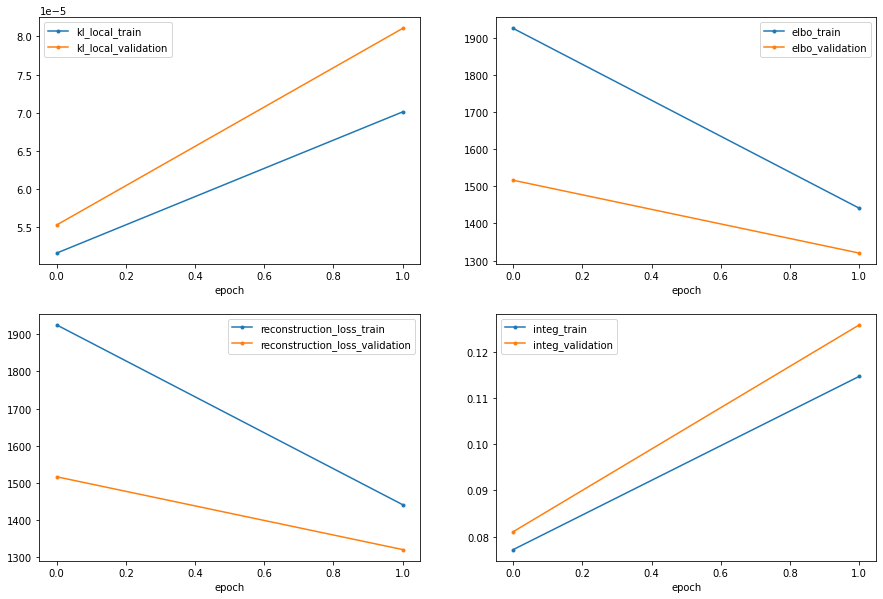

In [8]:
model.plot_losses()

# Inference

Get the latent representation.

In [9]:
model.get_latent_representation()
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 90261 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'counts'

Visualize results.

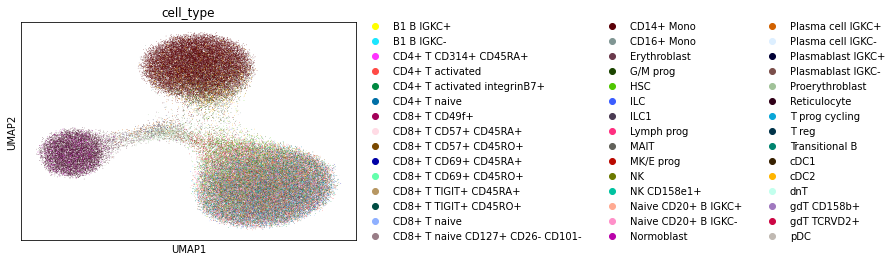

In [10]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')